In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score,RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from catboost import CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
# Show value counts for selected categorical columns
cols_to_show = ['brand', 'model', 'transmission', 'drivetrain', 'fuel_type', 'body_type']
for col in cols_to_show:
    if col in df_clean.columns:
        print(f"\n=== {col} value counts ===")
        print(df_clean[col].value_counts())
    else:
        print(f"\n=== {col} not found in df_clean ===")



=== brand value counts ===
brand
Mercedes Benz    371
Volkswagen       205
Kia              164
Bmw              155
Peugeot          128
Audi             127
Land Rover        66
Hyundai           64
Toyota            62
Renault           61
Ford              57
Citroen           56
Seat              51
Great Wall        43
Fiat              40
Nissan            40
Suzuki            35
Mg                32
Porsche           30
Mazda             27
Jeep              27
Chery             25
Dacia             23
Skoda             21
Ssangyong         16
Opel              15
Mitsubishi        15
Chevrolet         12
Mahindra          12
Jaguar            10
Mini               9
Honda              9
Cupra              9
Isuzu              7
Alfa Romeo         6
Byd                5
Dongfeng           5
Ds                 4
Geely              4
Dfsk               3
Volvo              3
Hummer             2
Infiniti           2
Foton              2
Lancia             2
Wallyscar          2


In [15]:
df=pd.read_csv('cars_data_2.csv')
print(df.head())
# Now drop the unnecessary columns for modeling
columns_to_drop = [
    'listing_id', 'url', 'listing_date',  'price_rating','version','engine',
    'interior_color', 'exterior_color', 'upholstery', 'power_ch', 'cylinder_capacity', 'location'
]

df_clean = df.drop(columns=columns_to_drop, errors='ignore')

print("=== Cleaned Dataset Info ===")
print(f"Shape: {df_clean.shape}")
print(f"\nColumns kept: {list(df_clean.columns)}")
print(f"\nMissing values:\n{df_clean.isnull().sum()}")
print(f"\n=== Sample data ===")
print(df_clean.head(10))

                                                 url  listing_id  \
0  https://www.automobile.tn/fr/occasion/porsche/...      121095   
1  https://www.automobile.tn/fr/occasion/kia/spor...      120944   
2  https://www.automobile.tn/fr/occasion/suzuki/s...      121232   
3  https://www.automobile.tn/fr/occasion/volkswag...      121231   
4  https://www.automobile.tn/fr/occasion/mercedes...      117335   

           brand     model     version  mileage  year transmission  \
0        Porsche   Cayenne         NaN    99800  2006  Automatique   
1            Kia  Sportage         NaN    64000  2017     Manuelle   
2         Suzuki  S Presso    Pack Alu    20700  2023     Manuelle   
3     Volkswagen    Golf 7  7Smartline   150000  2015     Manuelle   
4  Mercedes Benz  Classe C      CAMG +    79000  2018  Automatique   

   drivetrain fuel_type  ...  previous_owners body_type exterior_color  \
0    Traction   Essence  ...        2ème main       SUV          Blanc   
1    Traction    Diese

In [16]:
# Replace missing values with median for numerical columns
df_clean['fuel_type'].fillna(df_clean['fuel_type'].mode()[0], inplace=True)
df_clean['car_condition'].fillna(df_clean['car_condition'].mode()[0], inplace=True)
df_clean['previous_owners'].fillna(df_clean['previous_owners'].mode()[0], inplace=True)
df_clean['body_type'].fillna(df_clean['body_type'].mode()[0], inplace=True)
df_clean['seats'].fillna(df_clean['seats'].median(), inplace=True)
df_clean['doors'].fillna(df_clean['doors'].median(), inplace=True)

print("=== Missing Values After Imputation ===")
print(df_clean.isnull().sum())

=== Missing Values After Imputation ===
brand              0
model              0
mileage            0
year               0
transmission       0
drivetrain         0
fuel_type          0
horsepower_cv      0
seller             0
price              0
car_condition      0
previous_owners    0
body_type          0
seats              0
doors              0
dtype: int64


C:\Users\awabz\AppData\Local\Temp\ipykernel_23756\1162019544.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['fuel_type'].fillna(df_clean['fuel_type'].mode()[0], inplace=True)
C:\Users\awabz\AppData\Local\Temp\ipykernel_23756\1162019544.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

In [17]:
# Convert seller to is_showroom (0 for Individual, 1 for showroom/dealer)
df_clean['is_showroom'] = (df_clean['seller'] != 'Individual').astype(int)

# Convert year to car age (2025 - year) and rename column to 'age'
df_clean['age'] = 2025 - df_clean['year']
df_clean = df_clean.drop(columns=['year'])

# Map car_condition to numeric codes (overwrite column)
condition_map = {
    'Très bon': 3,
    'Normal': 2,
    'Moyen': 1,
    'En panne / Accidenté': 0
}
df_clean['car_condition'] = df_clean['car_condition'].map(condition_map).astype('Int64')


print("=== is_showroom Distribution ===")
print(df_clean['is_showroom'].value_counts())
print(f"\nIndividual (0): {(df_clean['is_showroom'] == 0).sum()}")
print(f"Showroom (1): {(df_clean['is_showroom'] == 1).sum()}")

print("\n=== Car Age Feature ===")
print(f"Min age: {df_clean['age'].min()} years")
print(f"Max age: {df_clean['age'].max()} years")
print(f"Avg age: {df_clean['age'].mean():.1f} years")

print("\n=== Car Condition (Encoded) ===")
print(df_clean['car_condition'].value_counts().sort_index())


=== is_showroom Distribution ===
is_showroom
1    1184
0     891
Name: count, dtype: int64

Individual (0): 891
Showroom (1): 1184

=== Car Age Feature ===
Min age: 0 years
Max age: 35 years
Avg age: 7.2 years

=== Car Condition (Encoded) ===
car_condition
0       4
1       5
2     104
3    1962
Name: count, dtype: Int64


In [18]:
# Compute miles per year and drop original mileage
# If age <= 1, use mileage directly; otherwise mileage/age
age_safe = df_clean['age']
miles = df_clean['mileage']
df_clean['miles_per_year'] = miles.where(age_safe <= 1, miles / age_safe)

# Drop original mileage
df_clean = df_clean.drop(columns=['mileage'])

print("=== miles_per_year summary ===")
print(df_clean['miles_per_year'].describe())

=== miles_per_year summary ===
count     2075.000000
mean     18916.774728
std      10230.422058
min          0.000000
25%      12500.000000
50%      17200.000000
75%      23115.384615
max      80000.000000
Name: miles_per_year, dtype: float64


In [19]:
# Identify categorical and numeric columns in df_clean
cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df_clean.select_dtypes(include=['number', 'Int64']).columns.tolist()

print("Categorical columns:")
print(cat_cols)

print("\nNumeric columns:")
print(num_cols)

Categorical columns:
['brand', 'model', 'transmission', 'drivetrain', 'fuel_type', 'seller', 'previous_owners', 'body_type']

Numeric columns:
['horsepower_cv', 'price', 'car_condition', 'seats', 'doors', 'is_showroom', 'age', 'miles_per_year']


In [20]:
print("Possible values for previous_owners:")
print(df_clean['previous_owners'].unique())
print(df_clean['previous_owners'].describe())
df_clean['previous_owners'] = df_clean['previous_owners'].astype(str).str.strip().str[0]


Possible values for previous_owners:
['2ème main' '1ère main' '3 et +']
count          2075
unique            3
top       1ère main
freq           1458
Name: previous_owners, dtype: object


In [21]:
df_clean.drop('seller', axis=1, inplace=True)

In [22]:
# Show value counts for selected categorical columns
cols_to_show = ['brand', 'model', 'transmission', 'drivetrain', 'fuel_type', 'body_type']
for col in cols_to_show:
    if col in df_clean.columns:
        print(f"\n=== {col} value counts ===")
        print(df_clean[col].value_counts())
    else:
        print(f"\n=== {col} not found in df_clean ===")



=== brand value counts ===
brand
Mercedes Benz    371
Volkswagen       205
Kia              164
Bmw              155
Peugeot          128
Audi             127
Land Rover        66
Hyundai           64
Toyota            62
Renault           61
Ford              57
Citroen           56
Seat              51
Great Wall        43
Fiat              40
Nissan            40
Suzuki            35
Mg                32
Porsche           30
Mazda             27
Jeep              27
Chery             25
Dacia             23
Skoda             21
Ssangyong         16
Opel              15
Mitsubishi        15
Chevrolet         12
Mahindra          12
Jaguar            10
Mini               9
Honda              9
Cupra              9
Isuzu              7
Alfa Romeo         6
Byd                5
Dongfeng           5
Ds                 4
Geely              4
Dfsk               3
Volvo              3
Hummer             2
Infiniti           2
Foton              2
Lancia             2
Wallyscar          2


In [23]:

# Prepare data for modeling
X = df_clean.drop('price', axis=1)
y = df_clean['price']

# Identify categorical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Features: {X.shape[1]}")
print(f"Categorical features: {cat_cols}")
print(f"Target variable: price")
print(f"\nTotal samples: {len(X)}")

# Hyperparameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# Create base model
base_model = CatBoostRegressor(
    verbose=0,
    cat_features=cat_cols,
    random_state=42
)

# Grid search with 3-fold CV
print("\n=== Hyperparameter Tuning (Grid Search) ===")
print("Testing parameter combinations...")
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

print(f"\n=== Best Parameters ===")
print(grid_search.best_params_)
print(f"\nBest CV R² Score: {grid_search.best_score_:.4f}")

# Train final model with best parameters using 5-fold CV
print("\n=== 5-Fold Cross-Validation with Best Parameters ===")
best_model = CatBoostRegressor(
    iterations=grid_search.best_params_['iterations'],
    depth=grid_search.best_params_['depth'],
    learning_rate=grid_search.best_params_['learning_rate'],
    verbose=0,
    cat_features=cat_cols,
    random_state=42
)

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
cv_mse_scores = -cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mae_scores = -cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_absolute_error')

print(f"R² Scores: {cv_scores}")
print(f"Mean R²: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"\nMSE Scores: {cv_mse_scores}")
print(f"Mean MSE: {cv_mse_scores.mean():.2f} (+/- {cv_mse_scores.std():.2f})")
print(f"\nMAE Scores: {cv_mae_scores}")
print(f"Mean MAE: {cv_mae_scores.mean():.2f} (+/- {cv_mae_scores.std():.2f})")

# Train final model on full data
print("\n=== Training Final Model ===")
best_model.fit(X, y)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.get_feature_importance()
}).sort_values('importance', ascending=False)

print("\n=== Top 10 Important Features ===")
print(feature_importance.head(10))


Features: 14
Categorical features: ['brand', 'model', 'transmission', 'drivetrain', 'fuel_type', 'previous_owners', 'body_type']
Target variable: price

Total samples: 2075

=== Hyperparameter Tuning (Grid Search) ===
Testing parameter combinations...
Fitting 3 folds for each of 48 candidates, totalling 144 fits


KeyboardInterrupt: 

In [24]:


# =========================================================
# 1. Feature Engineering
# =========================================================
df_clean["age_squared"] = df_clean["age"] ** 2
df_clean["miles_per_year_squared"] = df_clean["miles_per_year"] ** 2
df_clean["condition_age_ratio"] = df_clean["car_condition"] / (df_clean["age"].replace(0, 1))

# =========================================================
# 2. Data Prep
# =========================================================
X = df_clean.drop("price", axis=1)
y = df_clean["price"]

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print(f"Features: {X.shape[1]}")
print(f"Categorical: {cat_cols}")
print(f"Samples: {len(X)}")

# =========================================================
# 3. Stratified K-Fold (based on price distribution)
# =========================================================
price_bins = pd.qcut(y, q=5, labels=False)  # 5 equal-frequency bins
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# =========================================================
# 4. Hyperparameter Grid (Optimized)
# =========================================================
param_dist = {
    "iterations": [200, 300, 500],
    "depth": [4, 6, 8],
    "learning_rate": [0.03, 0.05, 0.1],
    "l2_leaf_reg": [3, 5, 7, 10, 15],
    "subsample": [0.7, 0.85, 1.0],
    "rsm": [0.7, 0.85, 1.0],
    "min_data_in_leaf": [5, 10, 20],
    "grow_policy": ["SymmetricTree", "Lossguide"],
    "loss_function": ["MAE", "RMSE"]
}

# =========================================================
# 5. Base Model
# =========================================================
base_model = CatBoostRegressor(
    verbose=0,
    cat_features=cat_cols,
    random_state=42
)

# =========================================================
# 6. Randomized Search (Much Better Than Grid Search)
# =========================================================
print("\n=== Starting Randomized Search ===")

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=25,                  # try 25 random combinations
    scoring="neg_mean_absolute_error",
    cv=skf,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X, y)

print("\n=== Best Parameters Found ===")
print(random_search.best_params_)

# =========================================================
# 7. Cross-validation with Best Model
# =========================================================
best_model = CatBoostRegressor(
    **random_search.best_params_,
    cat_features=cat_cols,
    verbose=0,
    random_state=42
)

print("\n=== 5-Fold CV Scores ===")

# MAE
cv_mae = -cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"MAE: {cv_mae.mean():.2f} (+/- {cv_mae.std():.2f})")

# R2
cv_r2 = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print(f"R2: {cv_r2.mean():.4f} (+/- {cv_r2.std():.4f})")

# RMSE
cv_rmse = np.sqrt(-cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error'))
print(f"RMSE: {cv_rmse.mean():.2f} (+/- {cv_rmse.std():.2f})")

# =========================================================
# 8. Fit Final Model on Full Data (with Early Stopping)
# =========================================================
print("\n=== Training Final Model with Early Stopping ===")

best_model.fit(
    X, y,
    eval_set=(X, y),
    early_stopping_rounds=50
)

# =========================================================
# 9. Feature Importance
# =========================================================
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": best_model.get_feature_importance()
}).sort_values(by="importance", ascending=False)

print("\n=== Top 15 Important Features ===")
print(feature_importance.head(15))


Features: 17
Categorical: ['brand', 'model', 'transmission', 'drivetrain', 'fuel_type', 'previous_owners', 'body_type']
Samples: 2075

=== Starting Randomized Search ===
Fitting 3 folds for each of 25 candidates, totalling 75 fits


c:\Users\awabz\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



=== Best Parameters Found ===
{'subsample': 1.0, 'rsm': 1.0, 'min_data_in_leaf': 20, 'loss_function': 'MAE', 'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 300, 'grow_policy': 'Lossguide', 'depth': 8}

=== 5-Fold CV Scores ===
MAE: 14647.34 (+/- 2822.70)
MAE: 14647.34 (+/- 2822.70)
R2: 0.8466 (+/- 0.0432)
R2: 0.8466 (+/- 0.0432)
RMSE: 26108.93 (+/- 5568.37)

=== Training Final Model with Early Stopping ===
RMSE: 26108.93 (+/- 5568.37)

=== Training Final Model with Early Stopping ===

=== Top 15 Important Features ===
                   feature  importance
5            horsepower_cv   20.150096
2             transmission   12.648049
0                    brand   11.865439
1                    model   10.741307
4                fuel_type   10.369866
3               drivetrain    7.989572
12                     age    7.410260
14             age_squared    6.259233
16     condition_age_ratio    4.792173
8                body_type    2.554327
15  miles_per_year_squared    2.290462


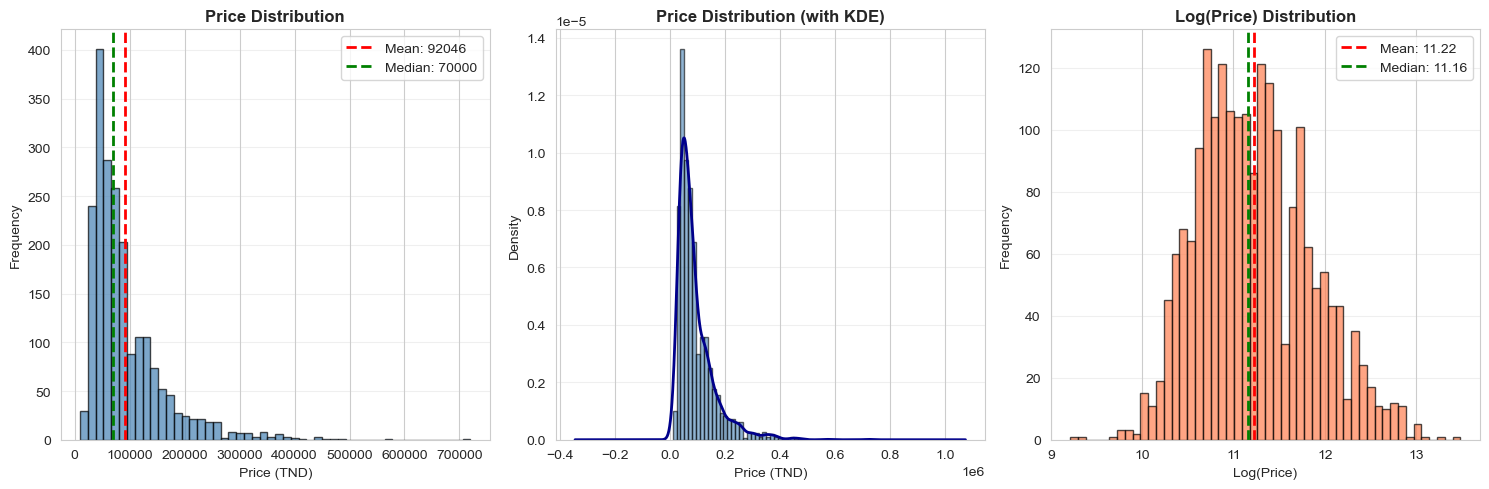

=== Price Summary Statistics ===
count      2075.000000
mean      92045.734940
std       68692.529432
min       10000.000000
25%       47000.000000
50%       70000.000000
75%      117000.000000
max      720000.000000
Name: price, dtype: float64

Skewness: 2.431
Kurtosis: 9.145

=== Log(Price) Summary Statistics ===
count    2075.000000
mean       11.224545
std         0.618300
min         9.210340
25%        10.757903
50%        11.156251
75%        11.669929
max        13.487006
Name: price, dtype: float64

Skewness: 0.411
Kurtosis: -0.134


In [31]:

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Price Distribution (Histogram)
axes[0].hist(df_clean['price'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Price Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Price (TND)')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', alpha=0.3)

# Add stats
price_mean = df_clean['price'].mean()
price_median = df_clean['price'].median()
axes[0].axvline(price_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {price_mean:.0f}')
axes[0].axvline(price_median, color='green', linestyle='--', linewidth=2, label=f'Median: {price_median:.0f}')
axes[0].legend()

# 2. Price Distribution with KDE
axes[1].hist(df_clean['price'], bins=50, color='steelblue', edgecolor='black', alpha=0.6, density=True)
df_clean['price'].plot(kind='kde', ax=axes[1], color='darkblue', linewidth=2)
axes[1].set_title('Price Distribution (with KDE)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Price (TND)')
axes[1].set_ylabel('Density')
axes[1].grid(axis='y', alpha=0.3)

# 3. Log(Price) Distribution
log_price = np.log(df_clean['price'])
axes[2].hist(log_price, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[2].set_title('Log(Price) Distribution', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Log(Price)')
axes[2].set_ylabel('Frequency')
axes[2].grid(axis='y', alpha=0.3)

# Add stats for log price
log_mean = log_price.mean()
log_median = log_price.median()
axes[2].axvline(log_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {log_mean:.2f}')
axes[2].axvline(log_median, color='green', linestyle='--', linewidth=2, label=f'Median: {log_median:.2f}')
axes[2].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== Price Summary Statistics ===")
print(df_clean['price'].describe())
print(f"\nSkewness: {df_clean['price'].skew():.3f}")
print(f"Kurtosis: {df_clean['price'].kurtosis():.3f}")

print("\n=== Log(Price) Summary Statistics ===")
print(log_price.describe())
print(f"\nSkewness: {log_price.skew():.3f}")
print(f"Kurtosis: {log_price.kurtosis():.3f}")


Numeric features: ['horsepower_cv', 'car_condition', 'seats', 'doors', 'is_showroom', 'age', 'miles_per_year', 'age_squared', 'miles_per_year_squared', 'condition_age_ratio']


IndexError: index 6 is out of bounds for axis 0 with size 6

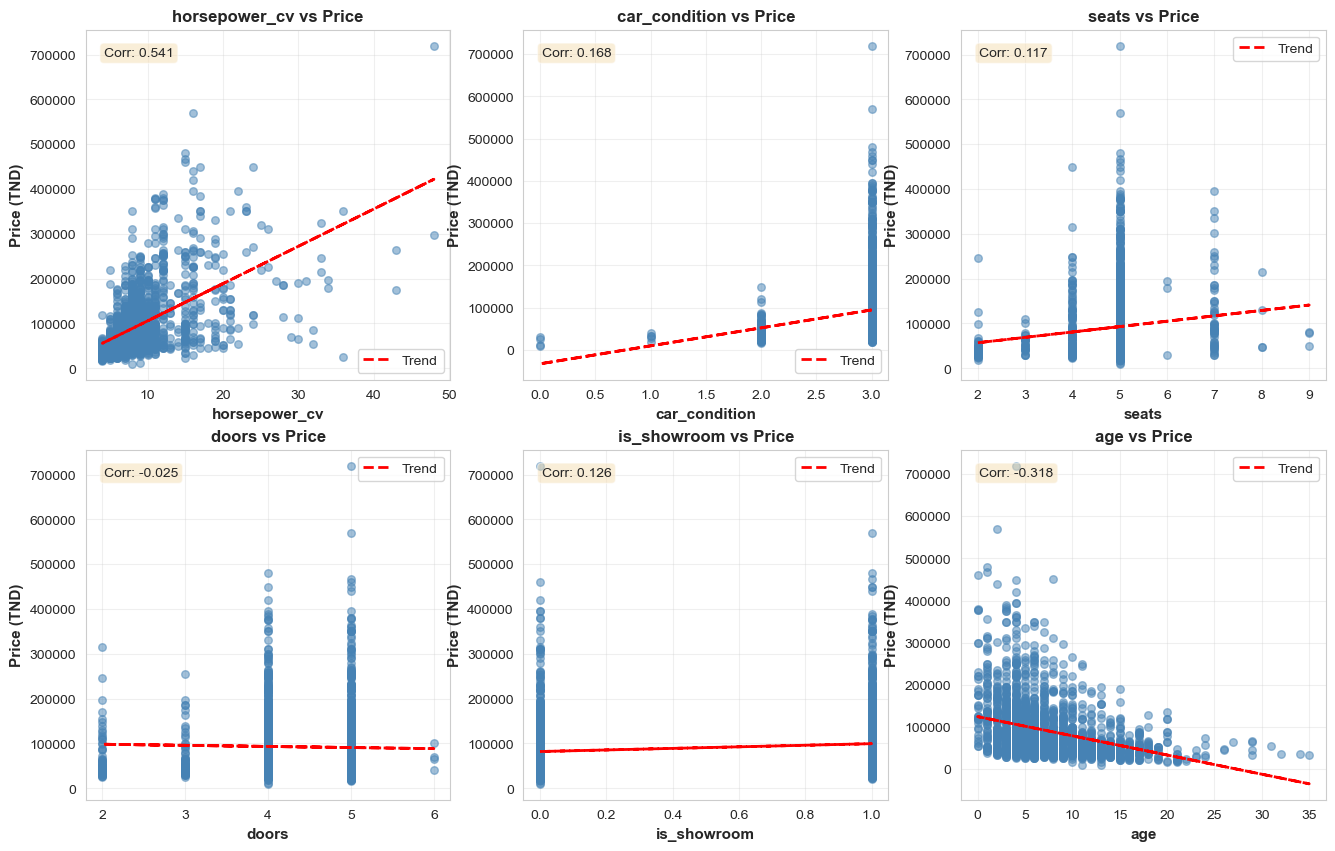

In [32]:
import seaborn as sns

# Get numeric columns (excluding price)
numeric_cols = df_clean.select_dtypes(include=['number', 'Int64']).columns.tolist()
numeric_cols.remove('price')  # Remove target from features

print(f"Numeric features: {numeric_cols}")

# Create subplots (2 rows x 3 columns = 6 plots)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()  # Flatten to 1D array for easier indexing

for idx, col in enumerate(numeric_cols):
    # Scatter plot with regression line
    axes[idx].scatter(df_clean[col], df_clean['price'], alpha=0.5, s=30, color='steelblue')
    
    # Add regression line
    z = np.polyfit(df_clean[col], df_clean['price'], 1)
    p = np.poly1d(z)
    axes[idx].plot(df_clean[col], p(df_clean[col]), "r--", linewidth=2, label='Trend')
    
    axes[idx].set_xlabel(col, fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Price (TND)', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{col} vs Price', fontsize=12, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    axes[idx].legend()
    
    # Calculate correlation
    corr = df_clean[col].corr(df_clean['price'])
    axes[idx].text(0.05, 0.95, f'Corr: {corr:.3f}', 
                   transform=axes[idx].transAxes, 
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print correlation matrix
print("\n=== Correlation with Price ===")
correlations = df_clean[numeric_cols + ['price']].corr()['price'].sort_values(ascending=False)
print(correlations)


C:\Users\awabz\AppData\Local\Temp\ipykernel_23756\3252326172.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top, x=col, y='price', ax=axes[idx], palette='Set2')
C:\Users\awabz\AppData\Local\Temp\ipykernel_23756\3252326172.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top, x=col, y='price', ax=axes[idx], palette='Set2')
C:\Users\awabz\AppData\Local\Temp\ipykernel_23756\3252326172.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top, x=col, y='price', ax=axes[idx], palette='Set2')
C:\Users\awabz\AppData

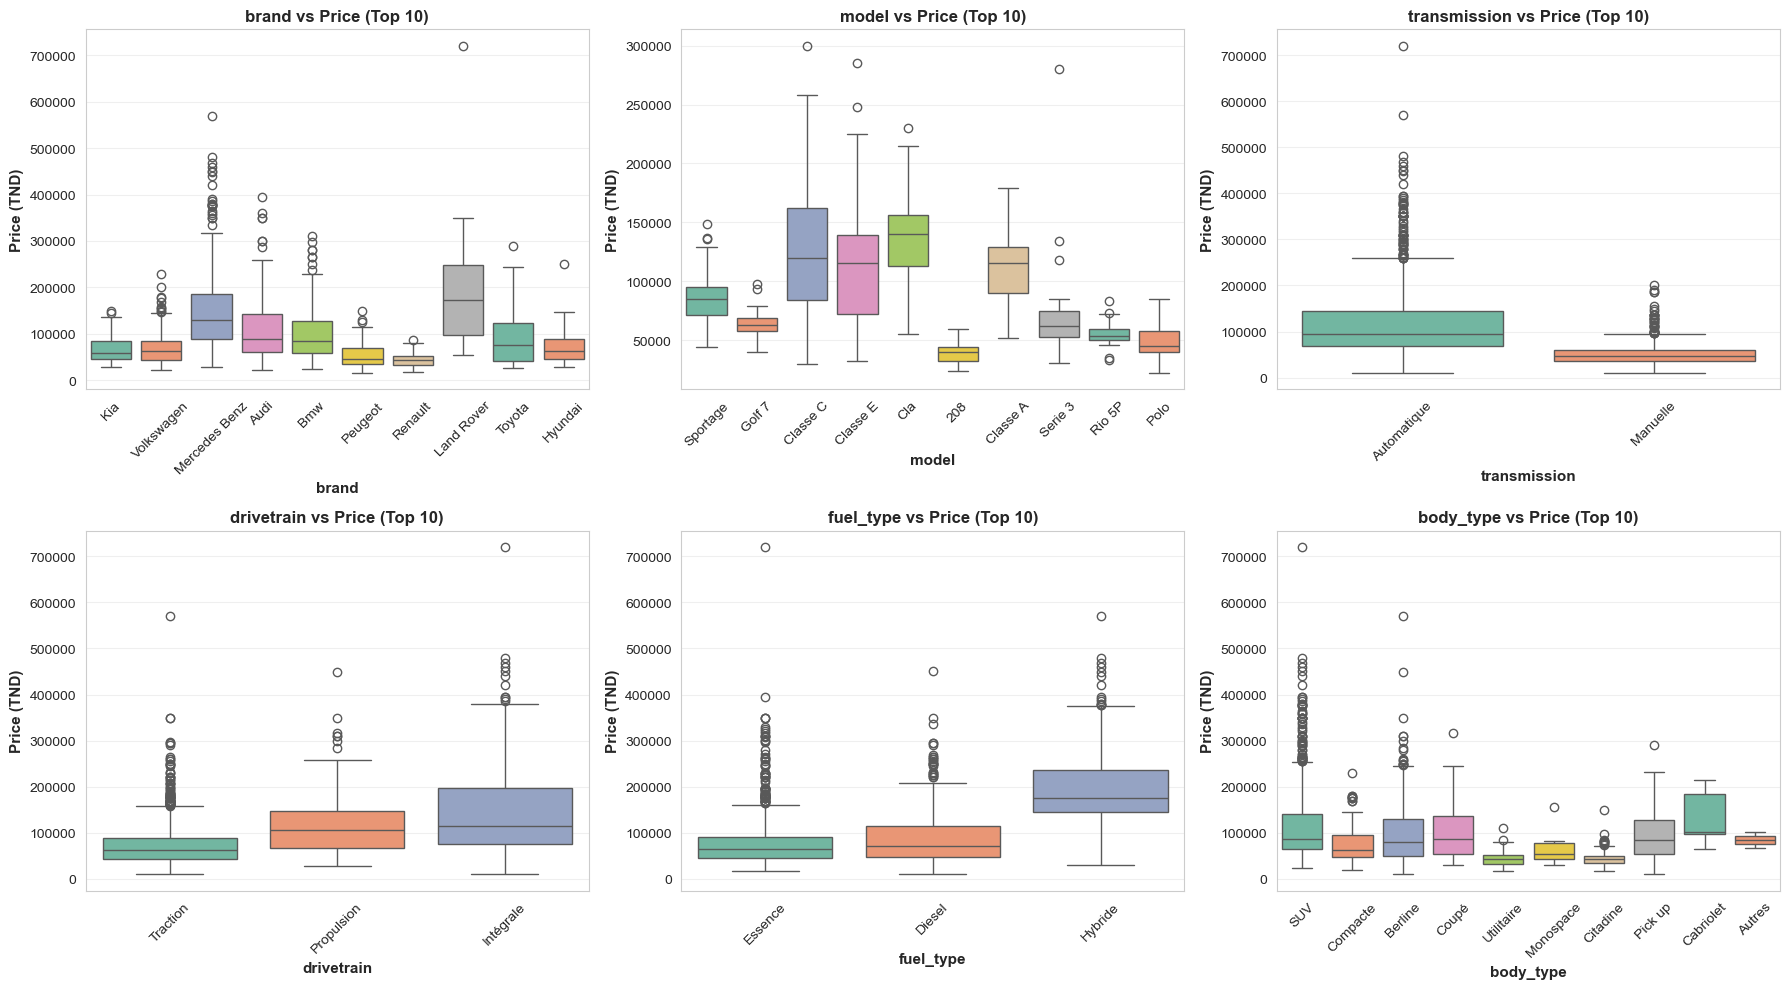

=== Price by Brand (Top 10) ===
Mercedes Benz        | Count:  371 | Mean:     150905 | Median:     130000 | Std:      88115
Volkswagen           | Count:  205 | Mean:      71218 | Median:      63000 | Std:      34611
Kia                  | Count:  164 | Mean:      67067 | Median:      58500 | Std:      25874
Bmw                  | Count:  155 | Mean:     102345 | Median:      85000 | Std:      61187
Peugeot              | Count:  128 | Mean:      52374 | Median:      45300 | Std:      23994
Audi                 | Count:  127 | Mean:     112783 | Median:      88500 | Std:      72866
Land Rover           | Count:   66 | Mean:     183136 | Median:     172000 | Std:     104996
Hyundai              | Count:   64 | Mean:      72822 | Median:      64000 | Std:      36842
Toyota               | Count:   62 | Mean:      92240 | Median:      76500 | Std:      58887
Renault              | Count:   61 | Mean:      44387 | Median:      43000 | Std:      14805

=== Price by Model (Top 10) ===
Class

In [33]:
# Categorical features vs Price
categorical_features = ['brand', 'model', 'transmission', 'drivetrain', 'fuel_type', 'body_type']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(categorical_features):
    # Get top 10 categories by frequency
    top_categories = df_clean[col].value_counts().head(10).index
    df_top = df_clean[df_clean[col].isin(top_categories)]
    
    # Box plot
    sns.boxplot(data=df_top, x=col, y='price', ax=axes[idx], palette='Set2')
    axes[idx].set_title(f'{col} vs Price (Top 10)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Price (TND)', fontsize=11, fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics for key categorical features
print("=== Price by Brand (Top 10) ===")
top_brands = df_clean['brand'].value_counts().head(10).index
for brand in top_brands:
    prices = df_clean[df_clean['brand'] == brand]['price']
    print(f"{brand:20s} | Count: {len(prices):4d} | Mean: {prices.mean():10.0f} | Median: {prices.median():10.0f} | Std: {prices.std():10.0f}")

print("\n=== Price by Model (Top 10) ===")
top_models = df_clean['model'].value_counts().head(10).index
for model in top_models:
    prices = df_clean[df_clean['model'] == model]['price']
    print(f"{model:20s} | Count: {len(prices):4d} | Mean: {prices.mean():10.0f} | Median: {prices.median():10.0f} | Std: {prices.std():10.0f}")

print("\n=== Price by Transmission ===")
for trans in df_clean['transmission'].unique():
    prices = df_clean[df_clean['transmission'] == trans]['price']
    print(f"{trans:20s} | Count: {len(prices):4d} | Mean: {prices.mean():10.0f} | Median: {prices.median():10.0f}")

print("\n=== Price by Fuel Type ===")
for fuel in df_clean['fuel_type'].unique():
    prices = df_clean[df_clean['fuel_type'] == fuel]['price']
    print(f"{fuel:20s} | Count: {len(prices):4d} | Mean: {prices.mean():10.0f} | Median: {prices.median():10.0f}")
